In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

# these are new 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 
import os                       # operating system tools (check files)

import geopandas as gpd # this is the main geopandas 
from shapely.geometry import Point, Polygon # also needed

import pyarrow as pa
import pyarrow.parquet as pq

##########################
# Then this stuff below allows us to make a nice inset


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#####################################################33
# on my laptop this issue arose and the suggested fix worked
# https://github.com/pyproj4/pyproj/issues/134

### Step 1: Get Shapefiles

The next couple of cells download the requisite shapefiles from the US census. They are unzipped in a folder called shapefiles and then county. So they are assuming some structure behind your folder setup. 

In [25]:
print("")
print("**********************************************************************************")
print("Downloading Shape files")
print("")

cwd = os.getcwd()

county_url = "https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip"
    
r = requests.get(county_url ) 

county_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

county_shapefile.extractall(path = cwd + "\\shapefiles\\county")

del r, county_shapefile


**********************************************************************************



Then do the same thing for states (so we can draw state lines as well). What's cool about these shapefiles is then you can layer on other stuff, roads, rivers, lakes.

In [26]:
state_url = "https://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip"
    
r = requests.get(state_url) 

state_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

state_shapefile.extractall(path = cwd + "\\shapefiles\\state")

del r, state_shapefile

### Step 2: Some basic cleaning

We will grab the tariff data, compute the tariff change. Then we will merge it with the geopandas dataframe

In [2]:
# Grab the tradedata...

file_path = os.getcwd()

fig_path = file_path +"\\figures"

trade_data = pq.read_table(file_path + "\\data\\trade_employment_blssingle19.parquet").to_pandas()

trade_data["time"] = pd.to_datetime(trade_data.time)

trade_data.set_index(["area_fips", "time"],inplace = True)

In [3]:
trade_data["tariff_change"] = trade_data.groupby(["area_fips"]).tariff.diff(12)

trade_data.sort_values(["area_fips", "time"], inplace = True)

In [4]:
trade_data.head()

total_exp_pc  china_exp_pc   tariff  emplvl_2017  fips  \
area_fips time                                                                 
1001      2016-01-01   1637.172755    110.997174  1.25745        891.0  1001   
          2016-02-01   1837.149069    124.989619  1.25745        891.0  1001   
          2016-03-01   2216.954481    154.993355  1.25745        891.0  1001   
          2016-04-01   2034.648337    200.967756  1.25745        891.0  1001   
          2016-05-01   2089.606285    207.235737  1.25745        891.0  1001   

                      total_employment  emp_rtl  emp_all  emp_gds  emp_ngds  \
area_fips time                                                                
1001      2016-01-01            6100.0   1712.0   8104.0   2125.0    5979.0   
          2016-02-01            6100.0   1735.0   8162.0   2121.0    6041.0   
          2016-03-01            6100.0   1740.0   8219.0   2105.0    6114.0   
          2016-04-01            6100.0   1726.0   8147.0   2130.0    6017.0   
          2016-05-01            6100.0   1711.0   8188.0   2135.0    6053.0   

                      rural_share  2010_population  2017_income  \
area_fips time                                                    
1001      2016-01-01     0.420022          54571.0      55317.0   
          2016-02-01     0.420022          54571.0      55317.0   
          2016-03-01     0.420022          54571.0      55317.0   
          2016-04-01     0.420022          54571.0      55317.0   
          2016-05-01     0.420022          54571.0      55317.0   

                      2017_population  tariff_change  
area_fips time                                        
1001      2016-01-01          55036.0            NaN  
          2016-02-01          55036.0            NaN  
          2016-03-01          55036.0            NaN  
          2016-04-01          55036.0            NaN  
          2016-05-01          55036.0            NaN

Now we will grab the county-level shapefile

In [5]:
cwd = os.getcwd()

county_shape = cwd + "\\shapefiles\\county\\tl_2017_us_county.shx"

us_map = gpd.read_file(county_shape)

us_map = us_map.to_crs({'init': 'epsg:3395'})

In [6]:
us_map["geometry"] = us_map["geometry"].simplify(200)
# This was important. The geometry in the tigerline file si
# too fine, orginal map was 350mb. simply basicly simplifies the geometry,
# making the map take up less memory and load faster. Still not sure
# what the number exactly means.

In [7]:
us_map.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477641638  10701538  +41.9158651   
1  G4020  None   None     None        A   680956787  61588406  +46.2946377   
2  G4020  None   None     None        A  6016761648  29147345  +34.3592729   
3  G4020   339  30700     None        A  2169252486  22867561  +40.7835474   
4  G4020  None   None     None        A  1489645186   1718484  +40.1764918   

       INTPTLON                                           geometry  
0  -096.7885168  POLYGON ((-10800163.11812986 5132991.983053582...  
1  -123.4244583  POLYGON ((-13740876.52543789 5787729.82287615,...  
2  -104.3686961  POLYGON ((-11640388.27442317 4004583.794358812...  
3  -096.6886584  POLYGON ((-10788038.53315113 4978192.963294434...  
4  -098.0468422  POLYGON ((-10939774.56882773 4851419.990907463...

A little bit more cleaning so a merge can be done.

In [8]:
us_map["area_fips"] = (us_map.STATEFP.astype(str) + us_map.COUNTYFP.astype(str)).astype(int)

In [9]:
tariff_df = trade_data.xs('2018-12-1', level=1).copy()

tariff_df["fips_code"] = tariff_df.index

tariff_df["fips_code"] = tariff_df["fips_code"].astype(int)

In [10]:
tariff_df.shape

(3252, 16)

In [11]:
lost_jobs = pd.read_csv(cwd + "\\data\\lost_jobs.csv")

lost_jobs.head()

GEOFIPS   lost_jobs
0     1001   -1.226787
1     1003  118.942883
2     1005   34.832945
3     1007   17.835350
4     1009   10.642294

In [12]:
tariff_df = tariff_df.merge(lost_jobs, left_on = "fips_code", right_on = "GEOFIPS", how = "inner", indicator = True)

Then merge the geopandas dataframe with the regular dataframe

In [13]:
us_map = us_map.merge(tariff_df[["tariff_change","2017_population","fips_code", "lost_jobs"]], left_on='area_fips',
                      right_on = "fips_code", how = "inner", indicator = True)

In [14]:
us_map.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP  ...    AWATER     INTPTLAT      INTPTLON  \
0  G4020  None  ...  10701538  +41.9158651  -096.7885168   
1  G4020  None  ...  61588406  +46.2946377  -123.4244583   
2  G4020  None  ...  29147345  +34.3592729  -104.3686961   
3  G4020   339  ...  22867561  +40.7835474  -096.6886584   
4  G4020  None  ...   1718484  +40.1764918  -098.0468422   

                                            geometry  area_fips tariff_change  \
0  POLYGON ((-10800163.11812986 5132991.983053582...      31039      3.029046   
1  POLYGON ((-13740876.52543789 5787729.82287615,...      53069      2.343937   
2  POLYGON ((-11640388.27442317 4004583.794358812...      35011      0.000000   
3  POLYGON ((-10788038.53315113 4978192.963294434...      31109      0.713917   
4  POLYGON ((-10939774.56882773 4851419.990907463...      31129      0.450309   

  2017_population fips_code   lost_jobs  _merge  
0          9039.0     31039   19.393539    both  
1          4105.0     53069    6.357348    both  
2          2016.0     35011    0.000000    both  
3        306357.0     31109  182.203943    both  
4          4318.0     31129    1.274618    both  

[5 rows x 24 columns]

Now we will drop Alaska and there stuff, bring in the state files too. Then plot.

In [15]:
us_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72"]

us_map.drop(drop_list, inplace = True)

In [16]:
state_shape = cwd + "\\shapefiles\\state\\tl_2017_us_state.shx"

state_map = gpd.read_file(state_shape)

state_map = state_map.to_crs({'init': 'epsg:3395'})

state_map["geometry"] = state_map["geometry"].simplify(200)

In [17]:
state_fp_dict = dict(zip(state_map.STATEFP, state_map.STUSPS))

In [18]:
state_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72","78","69","66","60",]

state_map.drop(drop_list, inplace = True)

In [19]:
us_map.reset_index(inplace = True)

In [20]:
us_map["STSPS"] = us_map["STATEFP"].map(state_fp_dict)

In [21]:
us_map["NAME"] = us_map["NAME"] + ", " + us_map["STSPS"]

In [22]:
us_map.set_index("STATEFP", inplace = True)

In [23]:
us_map["2017_population"] = us_map["2017_population"].map('{:,.0f}'.format)

In [24]:
us_map["lost_jobs"] = us_map["lost_jobs"] .round(0).astype(int)
us_map["lost_jobs"] = us_map["lost_jobs"].map('{:,.0f}'.format)

In [26]:
us_map["lost_cars"] = (-1.04)*us_map["tariff_change"]

In [29]:
us_map["lost_cars"] = us_map["lost_cars"].map('{:,.2f}'.format)

### Step 3: Plot it. 

That's what we do below

In [30]:
us_map["q_tariff"] = pd.qcut(us_map["tariff_change"], 10,labels = False, duplicates='drop')

us_map.q_tariff.replace(np.nan,0,inplace = True)

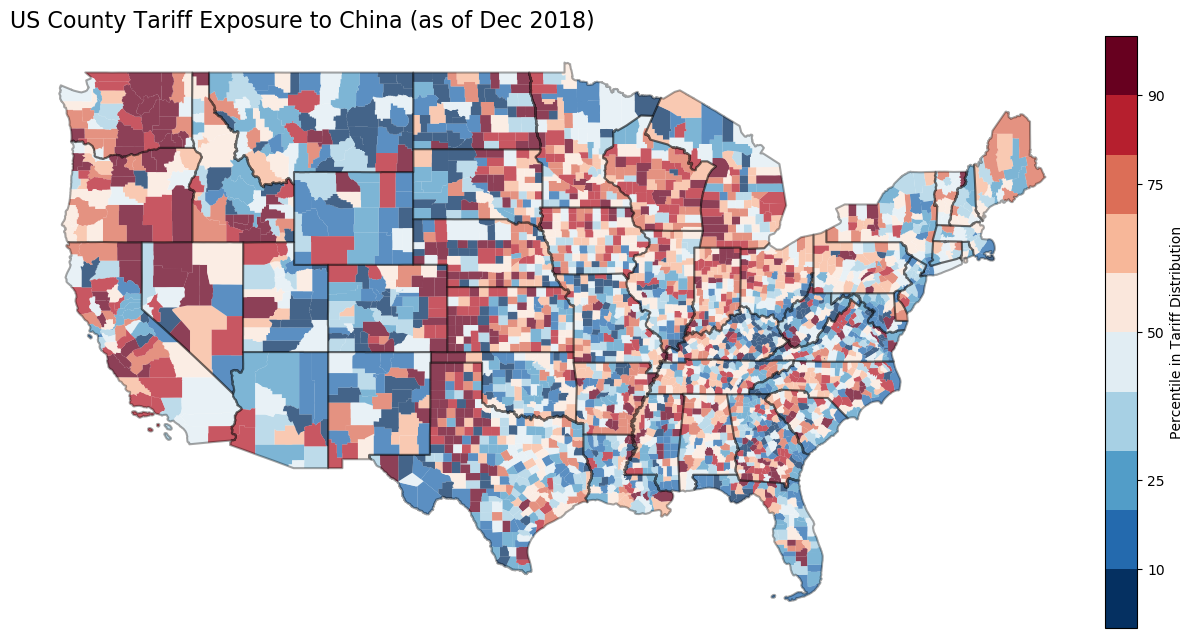

In [221]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize = (12,8))

plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

#################################################################################
# This is for the colorbar...

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=0.1)

#################################################################################
## This creates a discrete colorbar scheme...
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a

N = 10

base = plt.cm.get_cmap("RdBu_r")

color_list = base(np.linspace(0, 1, N))

cmap_name = base.name + str(N)

dcmap =  base.from_list(cmap_name, color_list, N)

#################################################################################
# This is the normal mapping...

us_map.plot(column='q_tariff', ax = ax,
              # THIS IS NEW, it says color it based on this column
             cmap=dcmap, 
             alpha = 0.75,
             vmin=0, vmax=us_map.q_tariff.max())

#################################################################################
# This then alows me to generate and edit the colorbar....
# https://stackoverflow.com/questions/53158096/editing-colorbar-legend-in-geopandas

sm = plt.cm.ScalarMappable(cmap=dcmap)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cbr.set_label('Percentile in Tariff Distribution')
cbr.set_alpha(0.15)

cbr.set_ticks([0.10, 0.25,0.50,0.75, 0.90])
cbr.set_ticklabels(["10","25","50","75","90"], update_ticks=True)

#################################################################################

state_map.geometry.boundary.plot(color=None, edgecolor='k', alpha = 0.35, ax = ax)

#################################################################################
# Then some final stuff to clean things up....

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

ax.set_title("US County Tariff Exposure to China (as of Dec 2018)", fontsize = 16, loc= "left" )

#ax.text(-127,23, "Source: US Census, BLS", fontsize = 8)

#fig_path = "C:\\github\\expenditure_tradeshocks\\figures"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
plt.savefig(fig_path +"\\us_china_exports_map.png", bbox_inches = "tight", dip = 1200)

plt.show()

In [31]:
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.models import Title

from bokeh.plotting import figure, save

from bokeh.resources import CDN
from bokeh.embed import file_html

# Input GeoJSON source that contains features for plotting
#geosource = GeoJSONDataSource(geojson = us_map.to_json())

In [37]:
state_geosource = GeoJSONDataSource(geojson = state_map.to_json())

geosource = GeoJSONDataSource(geojson = us_map.to_json())

palette = brewer['RdBu'][10]

#https://docs.bokeh.org/en/latest/docs/reference/palettes.html

color_mapper = LinearColorMapper(palette = palette, low = 0, high = 10)

tick_labels = {0:"",2:"20",4:"40",6:"60",8:"80",10:""}

color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 20, height = 420,
                     border_line_color = None,
                     orientation = "vertical",
                     location=(0,0),major_label_overrides = tick_labels,
                     major_tick_line_alpha = 0)

label = "County-Level Tariff Exposure to China \n Colorbar reports percentile in tariff distribution"
# Create figure object.
p = figure( 
           plot_height = 530 ,
           plot_width = 850, 
           toolbar_location = 'below',
           tools = "box_zoom, reset")

descip = "Colorbar reports percentile in tariff distribution; Hover tool reports county name, tariff increase"
descip = descip + ", population, estimates of % change in autos and jobs lost"
p.add_layout(Title(text=descip, text_font_style="italic", text_font_size="9pt"), 'above')
p.add_layout(Title(text="County-Level Tariff Exposure to Chinese Retaliation", text_font_size="11pt"), 'above')

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.

states = p.patches('xs','ys', source = geosource,
                   fill_color = {"field" :'q_tariff',
                                 "transform" : color_mapper},
                   line_color = "gray", 
                   line_width = 0.25, 
                   fill_alpha = 1)

state_line = p.multi_line('xs','ys', source = state_geosource,
                   line_color = "black", 
                   line_width = 0.5)
# Create hover tool

p.add_tools(HoverTool(renderers = [states],
                      tooltips = [('County','@NAME'),
                                ('Tariff Increase','@tariff_change'),
                                ('Population','@2017_population'),
                                 ('Est. % Change in Auto Sales','@lost_cars'), 
                                 ('Est. Lost Jobs','@lost_jobs'),]))

#### Some features to make it a bit nicer. 

p.axis.visible = False
p.background_fill_color = "grey"
p.background_fill_alpha = 0.25

p.toolbar.autohide = True

p.add_layout(color_bar, "right")

## Send to doc file, create a webpage from doc file on github
# then had weebly webiste point to that .html file. That's how
# I got this to work.

file_path = os.getcwd()

doc_path = file_path +"\\docs"

outfp = doc_path + "\\us_china_exports_map.html"

# Save the map
save(p, outfp)

# Not sure if this is important, but seemed to start working once
# I ran it
html = file_html(p, CDN, outfp)

In [36]:
p.add_layout?

In [43]:
1.4e7

14000000.0

In [67]:
print("this\nhi")

this
hi
